### Waste classification model

### _Without Data Augmentation (using only the images present in the training dataset)_

Using TensorFlow backend.


(172, 293, 3)
22564


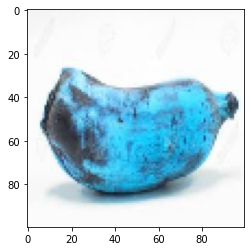

In [1]:
import pickle
import random
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

DATADIR = '/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN'
CATEGORIES = ['O', 'R']

for category in CATEGORIES:
    path = os.path.join(DATADIR, category) # path to O or R dir
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(img_array, cmap='gray')
        # plt.show()
        break
    break

print(img_array.shape)


IMG_SIZE = 100                             
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array)
# plt.show()

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category) # path to O or R dir
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE), 3)
                training_data.append([new_array, class_num])
            except Exception as e:
                pass
create_training_data()

print(len(training_data))

random.shuffle(training_data)

X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3) # 1: because it is grayscale

pickle_out = open('X.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('y.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation,Dropout
from keras.models import Model,load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.engine.topology import Layer
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import itertools

train_dir = '/kaggle/input/waste-classification-data/dataset/DATASET/TRAIN'
test_dir = '/kaggle/input/waste-classification-data/dataset/DATASET/TEST'

def load_dataset(path):
    data = load_files(path) #load all files from the path
    files = np.array(data['filenames']) #get the file  
    targets = np.array(data['target'])#get the the classification labels as integer index
    target_labels = np.array(data['target_names'])#get the the classification labels 
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.2,random_state = 1)

print ("x_train shape: " + str(x_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("x_validate shape: " + str(x_validate.shape))
print ("y_validate shape: " + str(y_validate.shape))
print ("x_test shape: " + str(x_test.shape))
print ("y_test shape: " + str(y_test.shape))

def convert_image_to_array(files):
    width, height, channels = 100, 100, 3
    images_as_array = np.empty((files.shape[0], width, height, channels), dtype=np.uint8) #define train and test data shape
    for idx,file in enumerate(files):
        img = cv2.imread(file) 
        res = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_CUBIC) #As images have different size, resizing all images to have same shape of image array
        images_as_array[idx] = res
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_validate))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
y_validate = y_validate.reshape(y_validate.shape[0],1)

Training set size :  22564
Testing set size :  2513
x_train shape: (18051,)
y_train shape: (18051,)
x_validate shape: (4513,)
y_validate shape: (4513,)
x_test shape: (2513,)
y_test shape: (2513,)
Training set shape :  (18051, 100, 100, 3)
Validation set shape :  (4513, 100, 100, 3)
Test set shape :  (2513, 100, 100, 3)


In [5]:
!ls

X.pickle  __notebook_source__.ipynb  y.pickle


### CNN model

In [6]:
def CNN_model():
    dense_layers = [0]
    layer_sizes = [128]
    conv_layers = [3]

    for dense_layer in dense_layers:
        for layer_size in layer_sizes:
            for conv_layer in conv_layers:
                NAME = "{}-conv-{}-nodes-{}-dense-{}".format(
                    conv_layer, layer_size, dense_layer, int(time.time()))
                print(NAME)

                model = Sequential()

                model.add(Conv2D(layer_size, (3, 3), input_shape=(100,100,3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

                for l in range(conv_layer-1):
                    model.add(Conv2D(layer_size, (3, 3)))
                    model.add(Activation('relu'))
                    model.add(MaxPooling2D(pool_size=(2, 2)))

                model.add(Flatten())

                for _ in range(dense_layer):
                    model.add(Dense(layer_size))
                    model.add(Activation('relu'))
                    model.add(Dropout(0.5))

                model.add(Dense(1))
                model.add(Activation('sigmoid'))
    #             print('came here')

                model.summary()
    return model

### Here there is going to be a huge number of images getting trained. Therefore, it is wise to use .fit_generator()

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0, # Randomly zoom image 
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)
print(x_train.shape)

(18051, 100, 100, 3)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
import pickle
import time
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint


# pickle_in = open("X.pickle", "rb")
# X = pickle.load(pickle_in)

# pickle_in = open("y.pickle", "rb")
# y = pickle.load(pickle_in)

# X = X/255.0
IMG_SIZE = 100
# X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# y = np.array(y)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model = CNN_model() # without data augmentation

checkpoint = ModelCheckpoint('128x3-CNN-no-aug.hdf5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor

model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

earlystop = EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 15, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

ReduceLR = ReduceLROnPlateau(patience=3, verbose=1)
callbacks = [earlystop, checkpoint, ReduceLR]

# model_details = model.fit(X, y,
#                     batch_size = 32,
#                     epochs = 12, # number of iterations
#                     validation_split=0.2,
#                     callbacks=[checkpoint],
#                     verbose=1)
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size= 32), epochs = 20, verbose=1,callbacks = callbacks,validation_data=(x_valid,y_validate))
# model.fit(X, y,
#             batch_size=32,
#             epochs=10,
#             validation_split=0.2)

model.save('128x3-CNN-no-aug.hdf5')

3-conv-128-nodes-0-dense-1591637563
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 98, 128)       3584      
_________________________________________________________________
activation_4 (Activation)    (None, 98, 98, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 128)       147584    
_________________________________________________________________
activation_5 (Activation)    (None, 47, 47, 128)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D) 

### Plotting graphs

{'loss': [0.45104006188961615, 0.39373303489944994, 0.36656195411364606, 0.34368987872880435, 0.3195297619809068, 0.29846647404937904, 0.266555163268237, 0.24265080993609353, 0.2112042841332151, 0.14700807313808373, 0.12928971831707586, 0.1198422468582775, 0.1091494955783699, 0.10740588272106917, 0.1064545342882084, 0.10512714862473577, 0.10500957572943605, 0.10491348959976714, 0.10476689454497948, 0.10475731212025223], 'accuracy': [0.8001219, 0.83225304, 0.84399754, 0.85646224, 0.8699795, 0.87623954, 0.8905324, 0.90266466, 0.9174007, 0.9470943, 0.9562905, 0.9594482, 0.9649881, 0.96559745, 0.96620685, 0.96653926, 0.96653926, 0.9667609, 0.96670544, 0.96670544], 'val_loss': [0.37441658096232383, 0.3390744874423501, 0.3731200919958538, 0.3422256557226723, 0.3096195055320842, 0.30566225442090217, 0.3354337384147124, 0.3226769837607982, 0.3500832021401511, 0.3311458458307179, 0.3401427660975254, 0.35515695960881466, 0.3486414181203502, 0.3502499193593665, 0.351525088371418, 0.35172460253793

Text(0.5, 17.25, 'Predicted label')

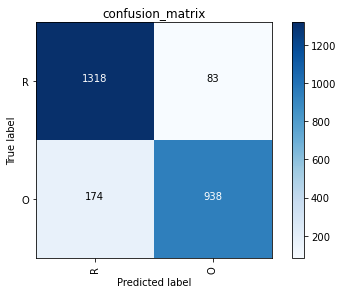

In [13]:
import pickle

pickle_out = open("Trained_cnn_history.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

pickle_in = open("Trained_cnn_history.pickle","rb")
saved_history = pickle.load(pickle_in)
print(saved_history)

import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

model = tf.keras.models.load_model("128x3-CNN-no-aug.hdf5")

score_train = model.evaluate(x_train, y_train, verbose=0)
print('\n\nTrain Loss: ', score_train[0])
print('Train Accuracy: ', score_train[1])

score = model.evaluate(x_test,y_test,verbose=0)
print('\nTest Loss :',score[0])
print('Test Accuracy :',score[1])

#get the predictions for the test data
predicted_classes = model.predict_classes(x_test)

confusion_mtx = confusion_matrix(y_test, predicted_classes) 

plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['R','O'], rotation=90)
plt.yticks(tick_marks, ['R','O'])
#Following is to mention the predicated numbers in the plot and highligh the numbers the most predicted number for particular label
thresh = confusion_mtx.max() / 2.
for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, confusion_mtx[i, j],
    horizontalalignment="center",
    color="white" if confusion_mtx[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

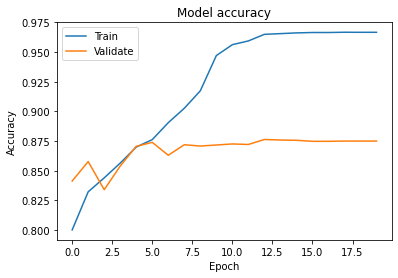

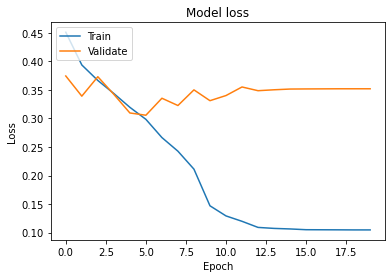

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

### _Data augmentation_

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)
print(x_train.shape)

(18051, 100, 100, 3)


### Training the model with augmented images

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
import pickle
import time
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
import keras


# pickle_in = open("X.pickle", "rb")
# X = pickle.load(pickle_in)

# pickle_in = open("y.pickle", "rb")
# y = pickle.load(pickle_in)

# X = X/255.0
IMG_SIZE = 100
# X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# y = np.array(y)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model = CNN_model() # with data augmentation

checkpoint = ModelCheckpoint('128x3-CNN-aug.hdf5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor

model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

# model_details = model.fit(X, y,
#                     batch_size = 32,
#                     epochs = 12, # number of iterations
#                     validation_split=0.2,
#                     callbacks=[checkpoint],
#                     verbose=1)


# --------------
earlystop = EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 15, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

ReduceLR = ReduceLROnPlateau(patience=3, verbose=1)
callbacks = [earlystop, checkpoint, ReduceLR]

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size= 32), epochs = 20, verbose=1,callbacks = callbacks,validation_data=(x_valid,y_validate))



# model.fit(X, y,
#             batch_size=32,
#             epochs=10,
#             validation_split=0.2)

model.save('128x3-CNN-aug.hdf5')

3-conv-128-nodes-0-dense-1591638040
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 128)       3584      
_________________________________________________________________
activation_12 (Activation)   (None, 98, 98, 128)       0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 128)       147584    
_________________________________________________________________
activation_13 (Activation)   (None, 47, 47, 128)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)

In [19]:
import pickle

pickle_out = open("Trained_cnn_history_my_model.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [20]:
pickle_in = open("Trained_cnn_history_my_model.pickle","rb")
saved_history = pickle.load(pickle_in)
print(saved_history)

{'loss': [0.47214599173390354, 0.42839885664068095, 0.3980396019640434, 0.37560809621136776, 0.35700791301862544, 0.3420872573878691, 0.33555996959199275, 0.3253416344057021, 0.31903393313096345, 0.3088717403358901, 0.28321828647872616, 0.2752641647960016, 0.2681543949858765, 0.2686773843125923, 0.26575916591796656, 0.2663301186055452, 0.2572540771012874, 0.2572751259659804, 0.2545676244559311, 0.2519403152449706], 'accuracy': [0.786937, 0.812642, 0.82826436, 0.8399535, 0.851421, 0.86050636, 0.8597308, 0.86759734, 0.86820674, 0.8739128, 0.8844385, 0.8897568, 0.89169574, 0.8943549, 0.89452106, 0.89291453, 0.89922994, 0.8974572, 0.8988976, 0.90033793], 'val_loss': [0.38972434229156594, 0.38290696454030326, 0.3484210574208251, 0.3272131422289837, 0.3165881749900434, 0.3122741457329947, 0.31191585255704646, 0.3163211080139396, 0.34039305370080614, 0.31991895900058187, 0.3002101588567503, 0.2866159341643291, 0.28418805775596434, 0.28957354095276405, 0.28004833324875295, 0.2759659331190383, 

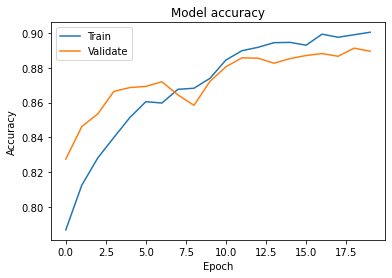

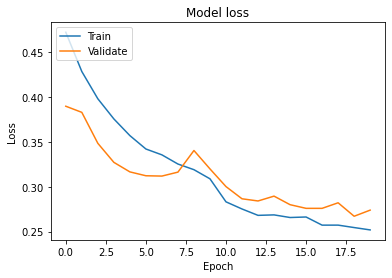

In [21]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

In [22]:
model = tf.keras.models.load_model('128x3-CNN-aug.hdf5')
# model.load_weights('128x3-CNN.hdf5')

score = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss :',score[0])
print('Test Accuracy :',score[1])

predicted_classes = model.predict_classes(x_test)


Test Loss : 0.27873201418625043
Test Accuracy : 0.8981297


Text(0.5, 17.25, 'Predicted label')

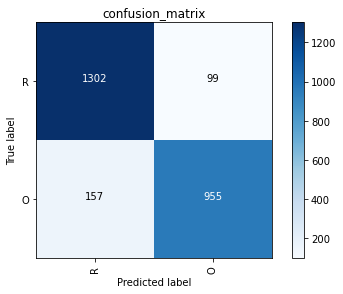

In [23]:
confusion_mtx = confusion_matrix(y_test, predicted_classes) 

plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['R','O'], rotation=90)
plt.yticks(tick_marks, ['R','O'])
#Following is to mention the predicated numbers in the plot and highligh the numbers the most predicted number for particular label
thresh = confusion_mtx.max() / 2.
for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, confusion_mtx[i, j],
    horizontalalignment="center",
    color="white" if confusion_mtx[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')